---
title: "Optimizing Aircraft Wing Weight with SpotOptim"
subtitle: "Surrogate-Based Optimization Tutorial"
format:
  html:
    code-fold: false
    toc: true
    toc-depth: 3
execute:
  cache: false
  eval: true
  echo: true
  warning: false
---

# Introduction

This tutorial demonstrates how to use **SpotOptim**, a surrogate-based Bayesian optimizer, to find the minimum weight configuration for an aircraft wing. We'll work through the 9-dimensional Aircraft Wing Weight Example (AWWE) from @Forr08a, showing all steps necessary for building a surrogate model and performing optimization.

## Learning Objectives

By the end of this tutorial, you will understand:

1. How to formulate a real-world engineering problem for optimization
2. How to set up and configure SpotOptim
3. How surrogate models work in Bayesian optimization
4. How to visualize optimization results
5. How to interpret surrogate model predictions

## The Aircraft Wing Weight Problem

We want to minimize the unpainted weight of a light aircraft wing as a function of nine design and operational parameters. The weight function is:

$$ W = 0.036 S_W^{0.758} \times W_{fw}^{0.0035} \left( \frac{A}{\cos^2 \Lambda} \right)^{0.6} \times  q^{0.006}  \times \lambda^{0.04} $$
$$ \times \left( \frac{100 R_{tc}}{\cos \Lambda} \right)^{-0.3} \times (N_z W_{dg})^{0.49}$$

### Design Parameters

The nine parameters with their bounds are:

| Parameter | Description | Min | Max | Baseline |
|-----------|-------------|-----|-----|----------|
| $S_W$ | Wing area (ft²) | 150 | 200 | 174 |
| $W_{fw}$ | Fuel weight (lb) | 220 | 300 | 252 |
| $A$ | Aspect ratio | 6 | 10 | 7.52 |
| $\Lambda$ | Quarter-chord sweep (deg) | -10 | 10 | 0 |
| $q$ | Dynamic pressure (lb/ft²) | 16 | 45 | 34 |
| $\lambda$ | Taper ratio | 0.5 | 1 | 0.672 |
| $R_{tc}$ | Airfoil thickness to chord | 0.08 | 0.18 | 0.12 |
| $N_z$ | Ultimate load factor | 2.5 | 6 | 3.8 |
| $W_{dg}$ | Design gross weight (lb) | 1700 | 2500 | 2000 |

# Step 1: Import Required Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spotoptim import SpotOptim, Kriging

# Set random seed for reproducibility
np.random.seed(42)

# Step 2: Implement the Objective Function

The objective function must:
1. Accept a 2D numpy array of shape `(n_samples, n_features)`
2. Return a 1D array of objective values
3. Map from the problem bounds to the natural scale

In [2]:
def wingwt(X):
    """
    Aircraft Wing Weight function.
    
    Parameters
    ----------
    X : ndarray of shape (n_samples, 9)
        Input parameters in their natural scales:
        [Sw, Wfw, A, Lambda, q, lambda, Rtc, Nz, Wdg]
    
    Returns
    -------
    W : ndarray of shape (n_samples,)
        Wing weight in pounds
    """
    X = np.atleast_2d(X)
    
    # Extract parameters (already on natural scale)
    Sw = X[:, 0]      # Wing area
    Wfw = X[:, 1]     # Fuel weight
    A = X[:, 2]       # Aspect ratio
    Lambda = X[:, 3]  # Quarter-chord sweep (degrees)
    q = X[:, 4]       # Dynamic pressure
    lam = X[:, 5]     # Taper ratio (lambda)
    Rtc = X[:, 6]     # Thickness to chord ratio
    Nz = X[:, 7]      # Load factor
    Wdg = X[:, 8]     # Design gross weight
    
    # Convert sweep angle to radians
    Lambda_rad = Lambda * np.pi / 180
    
    # Calculate wing weight using the formula
    W = 0.036 * Sw**0.758 * Wfw**0.0035
    W *= (A / np.cos(Lambda_rad)**2)**0.6
    W *= q**0.006 * lam**0.04
    W *= (100 * Rtc / np.cos(Lambda_rad))**(-0.3)
    W *= (Nz * Wdg)**0.49
    
    return W

Let's verify the function works with the baseline values:

In [3]:
# Baseline configuration
baseline = np.array([[174, 252, 7.52, 0, 34, 0.672, 0.12, 3.8, 2000]])
baseline_weight = wingwt(baseline)
print(f"Baseline wing weight: {baseline_weight[0]:.2f} lb")

Baseline wing weight: 233.83 lb


# Step 3: Define the Optimization Problem

We need to specify the bounds for each parameter:

In [4]:
# Define bounds: [(min, max), ...] for each of the 9 parameters
bounds = [
    (150, 200),    # Sw: Wing area
    (220, 300),    # Wfw: Fuel weight
    (6, 10),       # A: Aspect ratio
    (-10, 10),     # Lambda: Quarter-chord sweep
    (16, 45),      # q: Dynamic pressure
    (0.5, 1.0),    # lambda: Taper ratio
    (0.08, 0.18),  # Rtc: Thickness to chord ratio
    (2.5, 6.0),    # Nz: Load factor
    (1700, 2500)   # Wdg: Design gross weight
]

# Variable names for plotting and interpretation
var_names = ['Sw', 'Wfw', 'A', 'Lambda', 'q', 'lambda', 'Rtc', 'Nz', 'Wdg']

print(f"Optimization problem: Minimize wing weight")
print(f"Number of dimensions: {len(bounds)}")
print(f"Search space volume: {np.prod([b[1] - b[0] for b in bounds]):.2e}")

Optimization problem: Minimize wing weight
Number of dimensions: 9
Search space volume: 1.30e+09


# Step 4: Configure SpotOptim

SpotOptim uses Bayesian optimization with a surrogate model (Gaussian Process by default). Key configuration parameters:

- **n_initial**: Number of initial random samples (exploration)
- **max_iter**: Number of optimization iterations (exploitation)
- **acquisition**: Strategy for selecting next point ('ei' = Expected Improvement)
- **surrogate**: Model type (default GP or Kriging)

In [5]:
#| label: optimizer-setup
# Create optimizer with default Gaussian Process surrogate

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel

# Used a Matern kernel instead of the standard spotpython RBF kernel
kernel = ConstantKernel(1.0, (1e-2, 1e12)) * Matern(length_scale=1.0, length_scale_bounds=(1e-4, 1e2), nu=2.5)
S_GP = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)

optimizer = SpotOptim(
    fun=wingwt,
    bounds=bounds,
    n_initial=9,        # Initial space-filling design
    max_iter=100,         # Sequential optimization iterations
    acquisition='y',    # Expected Improvement acquisition function
    seed=42,             # Reproducibility
    verbose=True,         # Show progress
    surrogate=S_GP,    # Use custom GP surrogate from above
    max_surrogate_points=None  # Limit points used in surrogate training
)

print("\nOptimizer Configuration:")
print(f"  Initial samples: {optimizer.n_initial}")
print(f"  Optimization iterations: {optimizer.max_iter}")
print(f"  Total function evaluations: {optimizer.n_initial + optimizer.max_iter}")
print(f"  Acquisition function: {optimizer.acquisition}")
print(f"  Surrogate model: {type(optimizer.surrogate).__name__}")


Optimizer Configuration:
  Initial samples: 9
  Optimization iterations: 100
  Total function evaluations: 109
  Acquisition function: y
  Surrogate model: GaussianProcessRegressor


# Step 5: Run the Optimization

The optimization process consists of:

1. **Initial Design**: Generate space-filling samples using Latin Hypercube Sampling
2. **Sequential Loop**: For each iteration:
   - Fit surrogate model to all evaluated points
   - Use acquisition function to select next promising point
   - Evaluate objective function at new point
   - Update best solution if improved

In [6]:
#| label: run-optimization
print("\n" + "="*70)
print("STARTING OPTIMIZATION")
print("="*70 + "\n")

result = optimizer.optimize()

print("\n" + "="*70)
print("OPTIMIZATION COMPLETE")
print("="*70)


STARTING OPTIMIZATION

Initial best: f(x) = 174.460235
Iteration 1: f(x) = 181.922300
Iteration 2: f(x) = 192.186666
Iteration 3: New best f(x) = 170.527471
Iteration 4: New best f(x) = 144.648119
Iteration 5: f(x) = 184.198872
Iteration 6: f(x) = 146.523409
Iteration 7: f(x) = 145.421219
Iteration 8: f(x) = 222.370522
Iteration 9: New best f(x) = 142.986095
Iteration 10: f(x) = 144.978746
Iteration 11: f(x) = 333.211662
Iteration 12: f(x) = 358.643007
Iteration 13: f(x) = 237.643167
Iteration 14: f(x) = 188.515182
Iteration 15: f(x) = 239.037403
Iteration 16: f(x) = 164.795607
Iteration 17: f(x) = 224.799128
Iteration 18: f(x) = 145.876665
Iteration 19: f(x) = 144.781580
Iteration 20: f(x) = 212.657930
Iteration 21: f(x) = 224.770379
Iteration 22: f(x) = 192.488239
Iteration 23: f(x) = 241.495516
Iteration 24: f(x) = 222.866808
Iteration 25: f(x) = 143.114603
Iteration 26: f(x) = 143.549571
Iteration 27: f(x) = 220.546643
Iteration 28: New best f(x) = 142.307196
Iteration 29: f(x) = 

# Step 6: Analyze the Results

## Optimal Configuration

In [7]:
#| label: results-summary
print("\nOptimal Configuration Found:")
print("-" * 50)
for i, (name, value) in enumerate(zip(var_names, result.x)):
    baseline_val = baseline[0, i]
    change = ((value - baseline_val) / baseline_val) * 100
    print(f"{name:8s} = {value:8.3f}  (baseline: {baseline_val:7.3f}, change: {change:+6.1f}%)")

print("\n" + "="*50)
print(f"Optimal wing weight: {result.fun:.2f} lb")
print(f"Baseline weight:     {baseline_weight[0]:.2f} lb")
print(f"Weight reduction:    {baseline_weight[0] - result.fun:.2f} lb ({((baseline_weight[0] - result.fun)/baseline_weight[0]*100):.1f}%)")
print(f"Total evaluations:   {result.nfev}")
print("="*50)


Optimal Configuration Found:
--------------------------------------------------
Sw       =  150.000  (baseline: 174.000, change:  -13.8%)
Wfw      =  300.000  (baseline: 252.000, change:  +19.0%)
A        =    6.000  (baseline:   7.520, change:  -20.2%)
Lambda   =   10.000  (baseline:   0.000, change:   +inf%)
q        =   16.000  (baseline:  34.000, change:  -52.9%)
lambda   =    0.500  (baseline:   0.672, change:  -25.6%)
Rtc      =    0.180  (baseline:   0.120, change:  +50.0%)
Nz       =    2.500  (baseline:   3.800, change:  -34.2%)
Wdg      = 1700.000  (baseline: 2000.000, change:  -15.0%)

Optimal wing weight: 121.29 lb
Baseline weight:     233.83 lb
Weight reduction:    112.54 lb (48.1%)
Total evaluations:   109


## Optimization Progress

Let's visualize how the optimizer found better solutions over time:

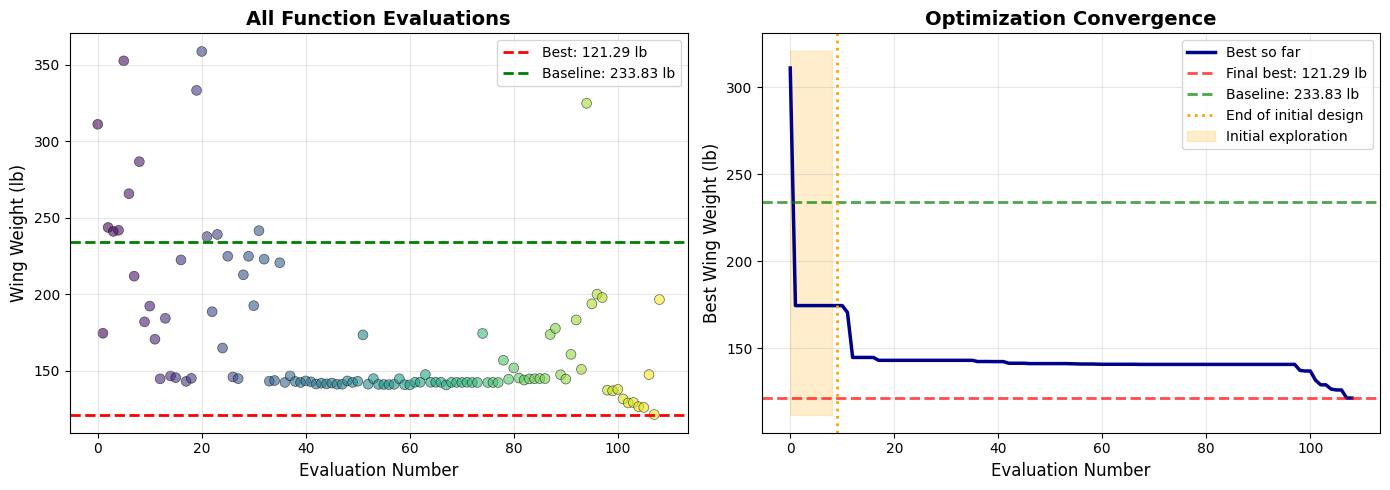

In [8]:
#| label: optimization-progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: All evaluated points
ax1.scatter(range(len(optimizer.y_)), optimizer.y_, 
           alpha=0.6, s=50, c=range(len(optimizer.y_)), 
           cmap='viridis', edgecolors='black', linewidth=0.5)
ax1.axhline(y=result.fun, color='r', linestyle='--', 
           linewidth=2, label=f'Best: {result.fun:.2f} lb')
ax1.axhline(y=baseline_weight[0], color='g', linestyle='--', 
           linewidth=2, label=f'Baseline: {baseline_weight[0]:.2f} lb')
ax1.set_xlabel('Evaluation Number', fontsize=12)
ax1.set_ylabel('Wing Weight (lb)', fontsize=12)
ax1.set_title('All Function Evaluations', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Best value found so far (convergence)
best_so_far = np.minimum.accumulate(optimizer.y_)
ax2.plot(best_so_far, linewidth=2.5, color='darkblue', label='Best so far')
ax2.axhline(y=result.fun, color='r', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'Final best: {result.fun:.2f} lb')
ax2.axhline(y=baseline_weight[0], color='g', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'Baseline: {baseline_weight[0]:.2f} lb')
ax2.axvline(x=optimizer.n_initial, color='orange', linestyle=':', 
           linewidth=2, label='End of initial design')
ax2.fill_between(range(optimizer.n_initial), 
                 ax2.get_ylim()[0], ax2.get_ylim()[1], 
                 alpha=0.2, color='orange', label='Initial exploration')
ax2.set_xlabel('Evaluation Number', fontsize=12)
ax2.set_ylabel('Best Wing Weight (lb)', fontsize=12)
ax2.set_title('Optimization Convergence', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Insights

In [9]:
#| label: key-insights
# Identify which parameters changed the most
changes = np.abs(result.x - baseline[0])
relative_changes = changes / (np.array([b[1] - b[0] for b in bounds]))
sorted_idx = np.argsort(relative_changes)[::-1]

print("\nParameters with Largest Changes (relative to search range):")
print("-" * 60)
for idx in sorted_idx[:5]:
    name = var_names[idx]
    opt_val = result.x[idx]
    base_val = baseline[0, idx]
    range_pct = relative_changes[idx] * 100
    print(f"{name:8s}: {base_val:7.3f} → {opt_val:7.3f}  (moved {range_pct:5.1f}% of range)")


Parameters with Largest Changes (relative to search range):
------------------------------------------------------------
q       :  34.000 →  16.000  (moved  62.1% of range)
Rtc     :   0.120 →   0.180  (moved  60.0% of range)
Wfw     : 252.000 → 300.000  (moved  60.0% of range)
Lambda  :   0.000 →  10.000  (moved  50.0% of range)
Sw      : 174.000 → 150.000  (moved  48.0% of range)


# Step 7: Visualize the Surrogate Model

The surrogate model captures the relationship between inputs and outputs. Let's visualize it for the two most important parameters.

In [10]:
#| label: surrogate-visualization
# Find the two parameters that changed the most
top_2_params = sorted_idx[:2]
i, j = top_2_params[0], top_2_params[1]

print(f"\nVisualizing surrogate model for {var_names[i]} (dim {i}) vs {var_names[j]} (dim {j})")
print("Other parameters fixed at their mean values from all evaluations.")


Visualizing surrogate model for q (dim 4) vs Rtc (dim 6)
Other parameters fixed at their mean values from all evaluations.


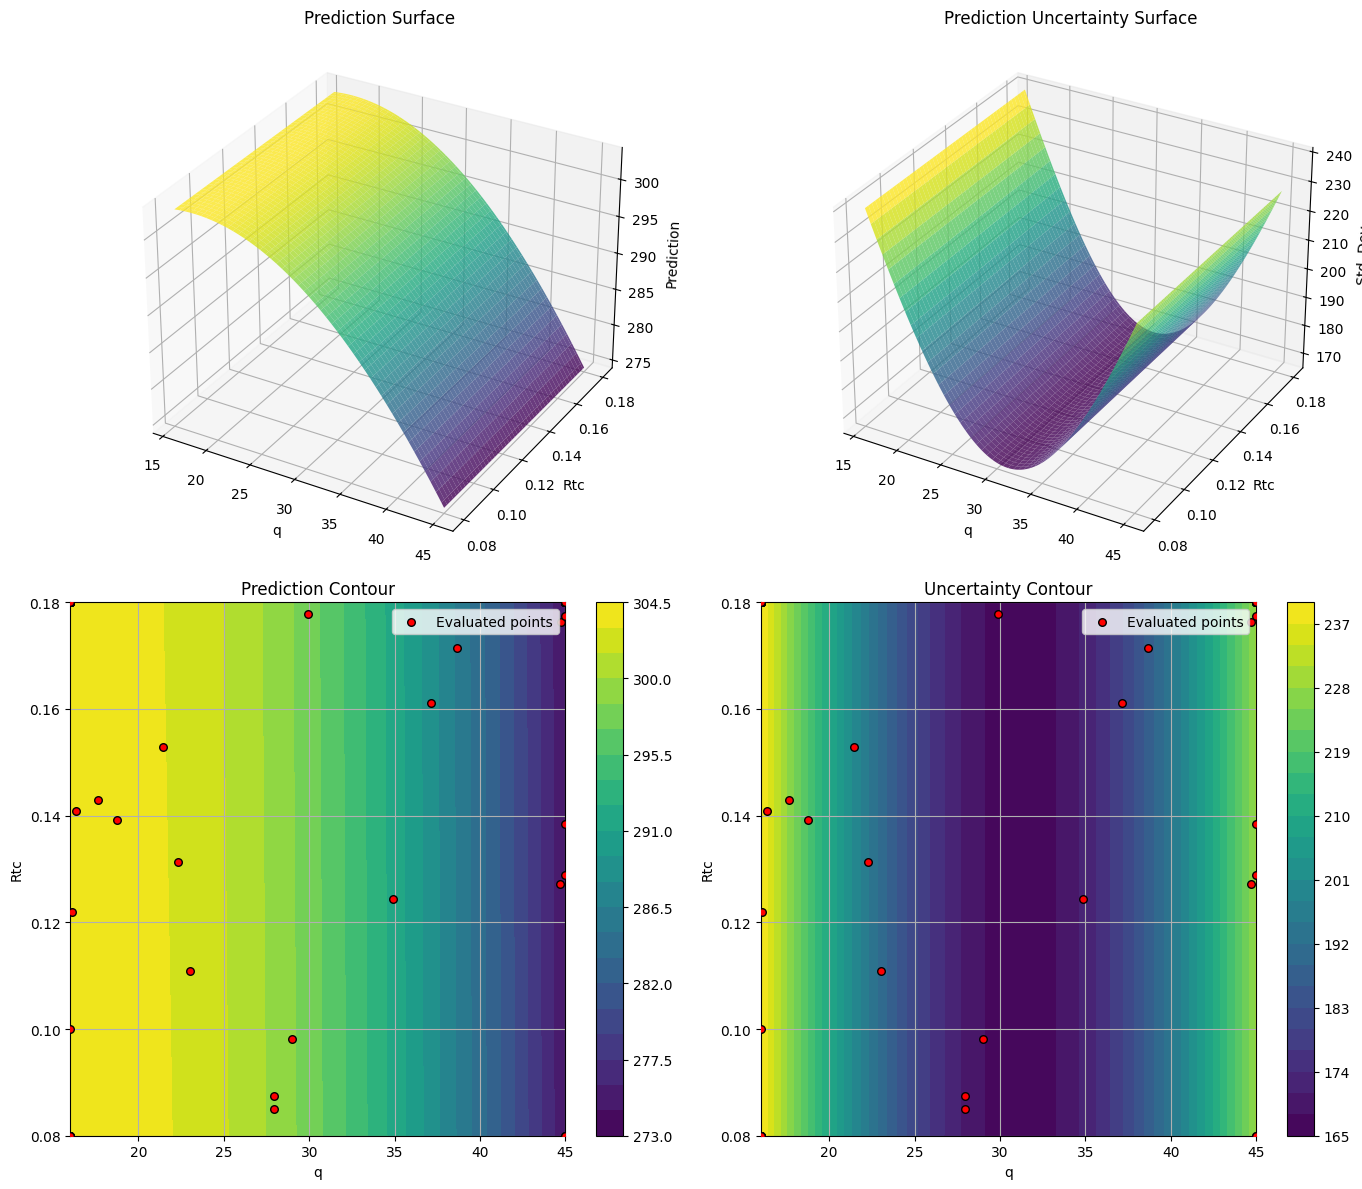

In [11]:
# Generate the surrogate visualization
optimizer.plot_surrogate(
    i=i, 
    j=j,
    var_name=var_names,
    add_points=True,
    cmap='viridis',
    contour_levels=25,
    figsize=(14, 12)
)

## Understanding the Surrogate Plot

The four panels show:

1. **Top Left - Prediction Surface**: The surrogate model's belief about wing weight across the parameter space
2. **Top Right - Uncertainty Surface**: Model uncertainty (high where we haven't explored)
3. **Bottom Left - Prediction Contour**: 2D view with evaluated points (red dots) overlaid
4. **Bottom Right - Uncertainty Contour**: Shows exploration strategy (uncertainty reduces near samples)

**Key observations:**
- Red dots show where we evaluated the true function
- Uncertainty is low near evaluated points (surrogate is confident)
- Uncertainty is high in unexplored regions (surrogate needs more data)
- The optimizer balances **exploitation** (searching near good points) and **exploration** (trying uncertain regions)

# Step 8: Compare Surrogate Model to Standard Optimization from scipy

scipy offers various optimization algorithms. Let's compare our surrogate-based approach to a standard gradient-based method like L-BFGS-B.

In [12]:
from scipy.optimize import minimize

# Track function evaluations during optimization
scipy_history = []

def wingwt_callback(X):
    """Callback to track function values during scipy optimization."""
    X = np.atleast_1d(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)
    y = wingwt(X)
    scipy_history.append(y[0] if isinstance(y, np.ndarray) else y)

# Run L-BFGS-B optimization from baseline
print("Running scipy L-BFGS-B optimization...")
res_scipy = minimize(
    fun=lambda x: wingwt(x.reshape(1, -1))[0],  # Scalar return for scipy
    x0=baseline[0],
    method='L-BFGS-B',
    bounds=bounds,
    callback=wingwt_callback,
    options={'maxiter': 100, 'ftol': 1e-6}
)

print(f"\nL-BFGS-B Results:")
print(f"  Final weight: {res_scipy.fun:.2f} lb")
print(f"  Success: {res_scipy.success}")
print(f"  Function evaluations: {res_scipy.nfev}")
print(f"  Message: {res_scipy.message}")

Running scipy L-BFGS-B optimization...

L-BFGS-B Results:
  Final weight: 119.50 lb
  Success: True
  Function evaluations: 520
  Message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL


Compare the convergence behavior of both methods:

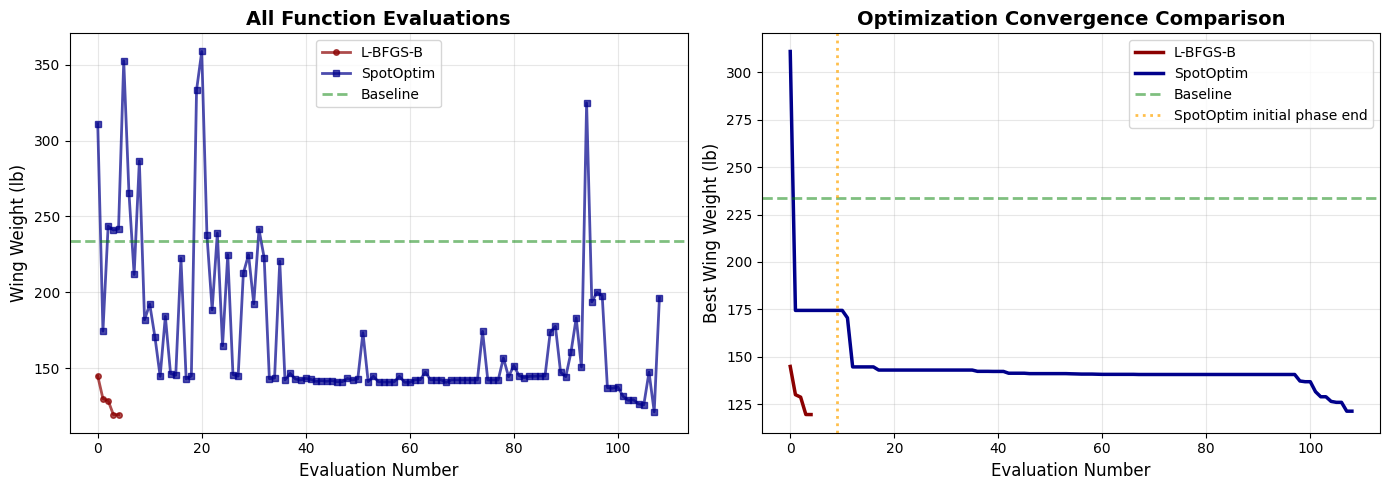

In [13]:
# Plot optimization progress comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Function evaluations over iterations
ax1.plot(scipy_history, marker='o', markersize=4, linewidth=2, 
         color='darkred', label='L-BFGS-B', alpha=0.7)
ax1.plot(optimizer.y_, marker='s', markersize=4, linewidth=2,
         color='darkblue', label='SpotOptim', alpha=0.7)
ax1.axhline(y=baseline_weight[0], color='green', linestyle='--', 
            linewidth=2, alpha=0.5, label='Baseline')
ax1.set_xlabel('Evaluation Number', fontsize=12)
ax1.set_ylabel('Wing Weight (lb)', fontsize=12)
ax1.set_title('All Function Evaluations', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Best value found so far (convergence)
scipy_best = np.minimum.accumulate(scipy_history)
spotoptim_best = np.minimum.accumulate(optimizer.y_)

ax2.plot(scipy_best, linewidth=2.5, color='darkred', label='L-BFGS-B')
ax2.plot(spotoptim_best, linewidth=2.5, color='darkblue', label='SpotOptim')
ax2.axhline(y=baseline_weight[0], color='green', linestyle='--', 
            linewidth=2, alpha=0.5, label='Baseline')
ax2.axvline(x=optimizer.n_initial, color='orange', linestyle=':', 
            linewidth=2, alpha=0.7, label='SpotOptim initial phase end')
ax2.set_xlabel('Evaluation Number', fontsize=12)
ax2.set_ylabel('Best Wing Weight (lb)', fontsize=12)
ax2.set_title('Optimization Convergence Comparison', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Analyze the comparison:

In [14]:
#| label: comparison-analysis
print("\n" + "="*70)
print("COMPARISON: SpotOptim vs L-BFGS-B")
print("="*70)
print(f"\n{'Method':<20s} {'Best Weight':>12s} {'Evaluations':>12s} {'Improvement':>12s}")
print("-"*70)
print(f"{'Baseline':<20s} {baseline_weight[0]:>12.2f} {'-':>12s} {'-':>12s}")
print(f"{'SpotOptim (BO)':<20s} {result.fun:>12.2f} {result.nfev:>12d} {((baseline_weight[0]-result.fun)/baseline_weight[0]*100):>11.1f}%")
print(f"{'L-BFGS-B (Gradient)':<20s} {res_scipy.fun:>12.2f} {res_scipy.nfev:>12d} {((baseline_weight[0]-res_scipy.fun)/baseline_weight[0]*100):>11.1f}%")
print("="*70)

print("\nKey Observations:")
print(f"  • L-BFGS-B found solution in {res_scipy.nfev} evaluations")
print(f"  • SpotOptim found solution in {result.nfev} evaluations")
print(f"  • L-BFGS-B final weight: {res_scipy.fun:.2f} lb")
print(f"  • SpotOptim final weight: {result.fun:.2f} lb")
print(f"  • Difference: {abs(res_scipy.fun - result.fun):.2f} lb")

if res_scipy.nfev < result.nfev:
    print(f"\n  → L-BFGS-B was more efficient (used {result.nfev - res_scipy.nfev} fewer evaluations)")
else:
    print(f"\n  → SpotOptim was more efficient (used {res_scipy.nfev - result.nfev} fewer evaluations)")

if res_scipy.fun < result.fun:
    print(f"  → L-BFGS-B found a better solution ({res_scipy.fun:.2f} vs {result.fun:.2f} lb)")
else:
    print(f"  → SpotOptim found a better solution ({result.fun:.2f} vs {res_scipy.fun:.2f} lb)")


COMPARISON: SpotOptim vs L-BFGS-B

Method                Best Weight  Evaluations  Improvement
----------------------------------------------------------------------
Baseline                   233.83            -            -
SpotOptim (BO)             121.29          109        48.1%
L-BFGS-B (Gradient)        119.50          520        48.9%

Key Observations:
  • L-BFGS-B found solution in 520 evaluations
  • SpotOptim found solution in 109 evaluations
  • L-BFGS-B final weight: 119.50 lb
  • SpotOptim final weight: 121.29 lb
  • Difference: 1.79 lb

  → SpotOptim was more efficient (used 411 fewer evaluations)
  → L-BFGS-B found a better solution (119.50 vs 121.29 lb)


# Summary and Key Takeaways

## What We Learned

1. **Problem Formulation**: Defined objective function and parameter bounds
2. **SpotOptim Setup**: Configured optimizer with appropriate hyperparameters
3. **Bayesian Optimization**: Balanced exploration and exploitation using surrogate models
4. **Results Analysis**: Found significant weight reduction compared to baseline
5. **Visualization**: Used surrogate plots to understand the optimization landscape
6. **Validation**: Verified surrogate model accuracy

## Optimization Results

In [15]:
#| label: final-summary
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nBaseline wing weight:  {baseline_weight[0]:.2f} lb")
print(f"Optimized weight:      {result.fun:.2f} lb")
print(f"Weight reduction:      {baseline_weight[0] - result.fun:.2f} lb ({((baseline_weight[0] - result.fun)/baseline_weight[0]*100):.1f}%)")
print(f"\nFunction evaluations:  {result.nfev}")
print(f"Success:               {result.success}")
print("="*70)


FINAL SUMMARY

Baseline wing weight:  233.83 lb
Optimized weight:      121.29 lb
Weight reduction:      112.54 lb (48.1%)

Function evaluations:  109
Success:               True


## Why Surrogate-Based Optimization?

For this problem, we could have used traditional optimization methods (gradient-based, genetic algorithms, etc.). However, surrogate-based optimization excels when:

1. **Expensive evaluations**: Each function call is costly (e.g., CFD simulations, physical experiments)
2. **Black-box functions**: No gradients available or function is noisy
3. **Limited budget**: Need to find good solutions with few evaluations
4. **Global optimization**: Want to explore the entire space, not just local optima

The surrogate model learns the function's behavior from evaluations, enabling intelligent sampling decisions.

# Homework Exercise

## Challenge: 10-Dimensional Problem with Paint Weight

Extend this tutorial to include paint weight as a 10th parameter:

$$ W = 0.036S_W^{0.758} \times W_{fw}^{0.0035} \times \left( \frac{A}{\cos^2 \Lambda} \right)^{0.6} \times q^{0.006} \times \lambda^{0.04} $$
$$ \times \left( \frac{100 R_{tc}}{\cos \Lambda} \right)^{-0.3} \times (N_z W_{dg})^{0.49} + S_w W_p$$

Where $W_p$ is paint weight per square foot with bounds [0.025, 0.08] lb/ft² and baseline 0.064 lb/ft².

### Tasks

1. Modify the `wingwt` function to include paint weight
2. Update the bounds and variable names
3. Run optimization with SpotOptim
4. Compare results with and without paint weight optimization
5. Analyze which parameters are most sensitive
6. Visualize the surrogate model for different parameter pairs

### Hints

- Add $W_p$ as the 10th dimension
- The paint weight contribution is: $S_w \times W_p$
- Consider how paint weight interacts with wing area

### Bonus Challenges

1. Try different acquisition functions: 'y', 'pi', 'ei'
2. Experiment with different numbers of initial samples
3. Compare GP vs Kriging surrogate performance
4. Implement constraints (e.g., minimum wing area for structural integrity)

Good luck! 🚀

# References

This tutorial is based on:

- Forrester, A., Sobester, A., & Keane, A. (2008). *Engineering Design via Surrogate Modelling: A Practical Guide*. Wiley.
- Aircraft wing weight function from Chapter 1.3

Additional resources:

- SpotOptim documentation: [GitHub Repository](https://github.com/sequential-parameter-optimization/spotoptim)
- Sequential Parameter Optimization Toolbox (SPOT) methodology